# Trabajo Práctico de Big Data

El objetivo de este trabajo práctico es utilizar técnicas de web scraping para obtener comentarios de películas de un sitio web, realizar el procesamiento de texto y analizar el sentimiento de los comentarios utilizando técnicas de análisis de texto. Además, se requiere la visualización de los resultados mediante gráficos para obtener una representación clara de los datos.

# El Peor Vecino del Mundo

## Web Scraping

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [3]:
base_url = "https://www.imdb.com/title/tt7405458/reviews/?ref_=tt_ql_2"

In [3]:
response = requests.get(base_url)

# Crear el objeto BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

In [4]:
response

<Response [200]>

In [5]:
headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

In [13]:
# Listas para almacenar los datos
contents = []
dates = []

# Número máximo de páginas adicionales a obtener
max_pages = 10

# Iterar sobre las páginas de reseñas
for page in range(1, max_pages + 1):
    # URL de la página actual
    url = f"{base_url}?start={((page - 1) * 10)}"

    # Realizar la solicitud HTTP
    response = requests.get(url)

    # Crear el objeto BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Encontrar todas las opiniones y reseñas
    reviews = soup.find_all("div", class_="lister-item-content")

    # Iterar sobre las reseñas y extraer los detalles deseados
    for review in reviews:
        # Contenido de la reseña
        content = review.find("div", class_="text").text.strip()
        contents.append(content)

        # Fecha de la reseña
        date_element = review.find("span", class_="review-date")
        date_match = re.search(r'\d+\s\w+\s\d+', date_element.text.strip())
        date = date_match.group() if date_match else "N/A"
        dates.append(date)

# Crear el DataFrame
data = {
    "Reseña": contents,
    "Tiempo": dates
}

dfv = pd.DataFrame(data)

dfv.head()

,Reseña,Tiempo
0,Living in a house on a closed-off oval of a st...,8 January 2023
1,"Based on the swedish movie ""En man som heter O...",3 March 2023
2,I absolutely loved A Man Called Otto I don't k...,12 January 2023
3,The Producers of this film would like you to f...,3 January 2023
4,Good grief there are some really grumpy review...,7 January 2023


In [7]:
dfv.shape

(250, 2)

## Procesamiento de Texto

In [14]:
# Clean the text
def clean(text):
    # Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
dfv['Reseña limpia'] = dfv['Reseña'].apply(clean)
dfv.head()

,Reseña,Tiempo,Reseña limpia
0,Living in a house on a closed-off oval of a st...,8 January 2023,Living in a house on a closed off oval of a st...
1,"Based on the swedish movie ""En man som heter O...",3 March 2023,Based on the swedish movie En man som heter Ov...
2,I absolutely loved A Man Called Otto I don't k...,12 January 2023,I absolutely loved A Man Called Otto I don t k...
3,The Producers of this film would like you to f...,3 January 2023,The Producers of this film would like you to f...
4,Good grief there are some really grumpy review...,7 January 2023,Good grief there are some really grumpy review...


### Tokenizacion

In [15]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
import nltk
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

dfv['POS tagged'] = dfv['Reseña limpia'].apply(token_stop_pos)
dfv.head()
# mydata['POS tagged'][0]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Reseña,Tiempo,Reseña limpia,POS tagged
0,Living in a house on a closed-off oval of a st...,8 January 2023,Living in a house on a closed off oval of a st...,"[(Living, v), (house, n), (closed, v), (oval, ..."
1,"Based on the swedish movie ""En man som heter O...",3 March 2023,Based on the swedish movie En man som heter Ov...,"[(Based, v), (swedish, a), (movie, n), (En, n)..."
2,I absolutely loved A Man Called Otto I don't k...,12 January 2023,I absolutely loved A Man Called Otto I don t k...,"[(absolutely, r), (loved, v), (Man, n), (Calle..."
3,The Producers of this film would like you to f...,3 January 2023,The Producers of this film would like you to f...,"[(Producers, n), (film, n), (would, None), (li..."
4,Good grief there are some really grumpy review...,7 January 2023,Good grief there are some really grumpy review...,"[(Good, a), (grief, n), (really, r), (grumpy, ..."


### Lemmatizacion

In [16]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

dfv['Lemma'] = dfv['POS tagged'].apply(lemmatize)
dfv.head()
# print(mydata['review'][239] + "\n" + mydata['Lemma'][239])

,Reseña,Tiempo,Reseña limpia,POS tagged,Lemma
0,Living in a house on a closed-off oval of a st...,8 January 2023,Living in a house on a closed off oval of a st...,"[(Living, v), (house, n), (closed, v), (oval, ...",Living house close oval street Otto neighbor...
1,"Based on the swedish movie ""En man som heter O...",3 March 2023,Based on the swedish movie En man som heter Ov...,"[(Based, v), (swedish, a), (movie, n), (En, n)...",Based swedish movie En man som heter Ove Man...
2,I absolutely loved A Man Called Otto I don't k...,12 January 2023,I absolutely loved A Man Called Otto I don t k...,"[(absolutely, r), (loved, v), (Man, n), (Calle...",absolutely love Man Called Otto know origina...
3,The Producers of this film would like you to f...,3 January 2023,The Producers of this film would like you to f...,"[(Producers, n), (film, n), (would, None), (li...",Producers film would like fall love grumpy m...
4,Good grief there are some really grumpy review...,7 January 2023,Good grief there are some really grumpy review...,"[(Good, a), (grief, n), (really, r), (grumpy, ...",Good grief really grumpy reviewer perfect ve...


## Análisis de Sentimiento

In [17]:
from textblob import TextBlob

# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [18]:
dfve = pd.DataFrame(dfv[['Tiempo', 'Reseña limpia', 'Lemma']])

In [19]:
dfve['Polarity'] = dfve['Lemma'].apply(getPolarity)
dfve['Analysis'] = dfve['Polarity'].apply(analysis)
dfve.head()

,Tiempo,Reseña limpia,Lemma,Polarity,Analysis
0,8 January 2023,Living in a house on a closed off oval of a st...,Living house close oval street Otto neighbor...,0.175284,Positive
1,3 March 2023,Based on the swedish movie En man som heter Ov...,Based swedish movie En man som heter Ove Man...,0.346429,Positive
2,12 January 2023,I absolutely loved A Man Called Otto I don t k...,absolutely love Man Called Otto know origina...,0.262980,Positive
3,3 January 2023,The Producers of this film would like you to f...,Producers film would like fall love grumpy m...,0.144608,Positive
4,7 January 2023,Good grief there are some really grumpy review...,Good grief really grumpy reviewer perfect ve...,0.287870,Positive


In [20]:
tb_counts = dfve.Analysis.value_counts()
tb_counts

Positive    230
Negative     20
Name: Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x7f95b3ed5b40>,
 [Text(-1.065441491584454, 0.2735588200191949, 'Positive'),
  Text(1.3075873008430892, -0.3357312179018877, 'Negative')],
 [Text(-0.5811499045006111, 0.14921390182865174, '92.0%'),
  Text(0.8232957079382413, -0.21138632238267002, '8.0%')])

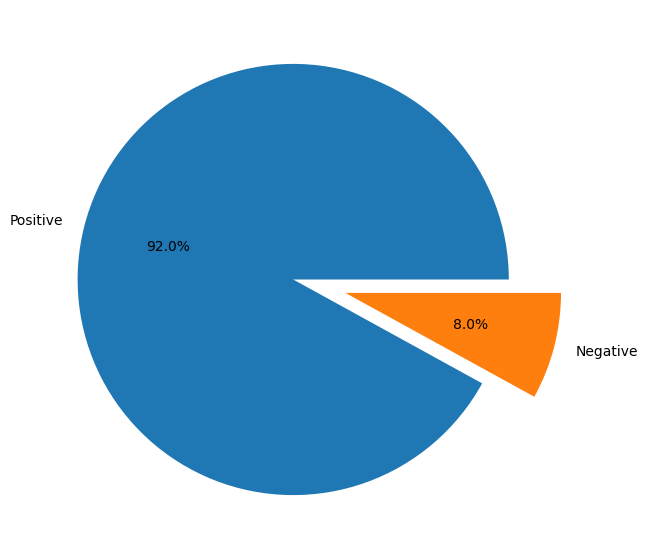

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

tb_count= dfve.Analysis.value_counts()
plt.figure(figsize=(10, 7))
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0.25), autopct='%1.1f%%', shadow=False)
# plt.legend()

Analisis con VADER

In [22]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.5 MB/s eta 0:00:00


In [23]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

dfve['Vader Sentiment'] = dfve['Lemma'].apply(vadersentimentanalysis)

In [24]:
# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'

dfve['Vader Analysis'] = dfve['Vader Sentiment'].apply(vader_analysis)
dfve.head()

,Tiempo,Reseña limpia,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis
0,8 January 2023,Living in a house on a closed off oval of a st...,Living house close oval street Otto neighbor...,0.175284,Positive,0.9181,Positive
1,3 March 2023,Based on the swedish movie En man som heter Ov...,Based swedish movie En man som heter Ove Man...,0.346429,Positive,0.9438,Positive
2,12 January 2023,I absolutely loved A Man Called Otto I don t k...,absolutely love Man Called Otto know origina...,0.262980,Positive,0.9790,Positive
3,3 January 2023,The Producers of this film would like you to f...,Producers film would like fall love grumpy m...,0.144608,Positive,0.9915,Positive
4,7 January 2023,Good grief there are some really grumpy review...,Good grief really grumpy reviewer perfect ve...,0.287870,Positive,0.9915,Positive


In [25]:
vader_counts = dfve['Vader Analysis'].value_counts()
vader_counts

Positive    230
Neutral      10
Negative     10
Name: Vader Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x7f95b3f39600>,
 [Text(-1.1622998090012224, 0.29842780365730354, 'Positive'),
  Text(1.0227541758021745, -0.40493690357784706, 'Neutral'),
  Text(1.0913261847411593, -0.137866451678084, 'Negative')],
 [Text(-0.6780082219173796, 0.17408288546676037, '92.0%'),
  Text(0.5578659140739134, -0.22087467467882566, '4.0%'),
  Text(0.5952688280406322, -0.07519988273350037, '4.0%')])

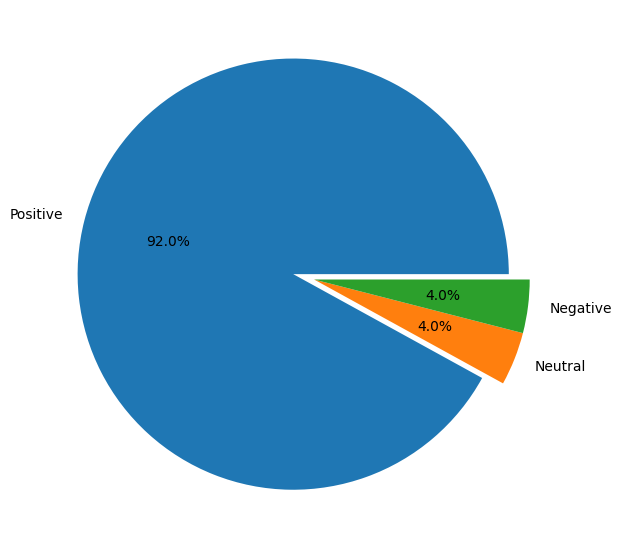

In [26]:
vader_counts= dfve['Vader Analysis'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)
# plt.legend()

## Visualización de Datos

In [27]:
dfve

,Tiempo,Reseña limpia,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis
0,8 January 2023,Living in a house on a closed off oval of a st...,Living house close oval street Otto neighbor...,0.175284,Positive,0.9181,Positive
1,3 March 2023,Based on the swedish movie En man som heter Ov...,Based swedish movie En man som heter Ove Man...,0.346429,Positive,0.9438,Positive
2,12 January 2023,I absolutely loved A Man Called Otto I don t k...,absolutely love Man Called Otto know origina...,0.262980,Positive,0.9790,Positive
3,3 January 2023,The Producers of this film would like you to f...,Producers film would like fall love grumpy m...,0.144608,Positive,0.9915,Positive
4,7 January 2023,Good grief there are some really grumpy review...,Good grief really grumpy reviewer perfect ve...,0.287870,Positive,0.9915,Positive
...,...,...,...,...,...,...,...
245,6 April 2023,I saw the Tom Hanks version and thought it was...,saw Tom Hanks version think good bit odd sce...,0.258442,Positive,0.9718,Positive
246,29 March 2023,The film was interesting I really liked the fa...,film interest really like father daughter re...,0.081481,Positive,0.8448,Positive
247,25 May 2023,This was probably Tom Hanks best films in the ...,probably Tom Hanks best film st century Otto...,0.239669,Positive,0.9719,Positive
248,14 January 2023,It is the first movie that i watch in in the ...,first movie watch theater first original mov...,0.335208,Positive,0.9969,Positive


In [22]:
dfve.shape

(250, 7)

([<matplotlib.patches.Wedge at 0x7f95b1da29b0>,
 [Text(-1.065441491584454, 0.2735588200191949, 'Positive'),
  Text(1.0227541758021745, -0.40493690357784706, 'Neutral'),
  Text(1.1905376560812646, -0.15039976546700073, 'Negative')],
 [Text(-0.5811499045006111, 0.14921390182865174, '92.0%'),
  Text(0.5578659140739134, -0.22087467467882566, '4.0%'),
  Text(0.6944802993807375, -0.0877331965224171, '4.0%')])

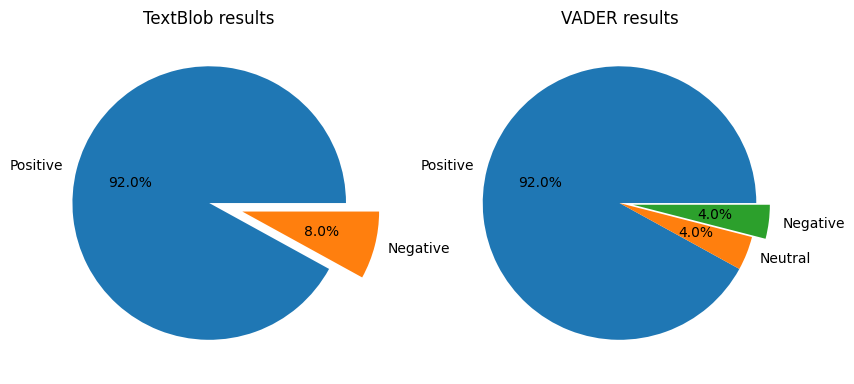

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title("TextBlob results")
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,2)
plt.title("VADER results")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.1), autopct='%1.1f%%', shadow=False)

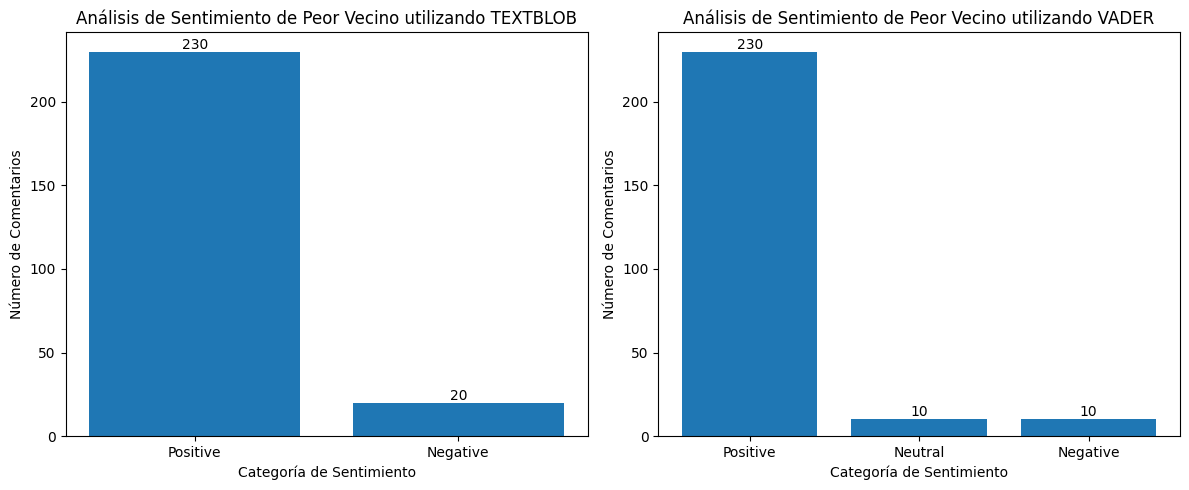

In [29]:
# Obtener el conteo de las categorías de sentimiento de df_f utilizando TEXTBLOB
sentimiento_counts_textblob_dfve = dfve['Analysis'].value_counts()

# Obtener el conteo de las categorías de sentimiento de df_f utilizando VADER
sentimiento_counts_vader_dfve = dfve['Vader Analysis'].value_counts()

# Crear una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: Análisis de sentimiento de df_f utilizando TEXTBLOB
axes[0].bar(sentimiento_counts_textblob_dfve.index, sentimiento_counts_textblob_dfve.values)
for i, count in enumerate(sentimiento_counts_textblob_dfve.values):
    axes[0].text(i, count, str(count), ha='center', va='bottom')
axes[0].set_title('Análisis de Sentimiento de Peor Vecino utilizando TEXTBLOB')
axes[0].set_xlabel('Categoría de Sentimiento')
axes[0].set_ylabel('Número de Comentarios')

# Gráfico 2: Análisis de sentimiento de df_f utilizando VADER
axes[1].bar(sentimiento_counts_vader_dfve.index, sentimiento_counts_vader_dfve.values)
for i, count in enumerate(sentimiento_counts_vader_dfve.values):
    axes[1].text(i, count, str(count), ha='center', va='bottom')
axes[1].set_title('Análisis de Sentimiento de Peor Vecino utilizando VADER')
axes[1].set_xlabel('Categoría de Sentimiento')
axes[1].set_ylabel('Número de Comentarios')

plt.tight_layout()
plt.show()

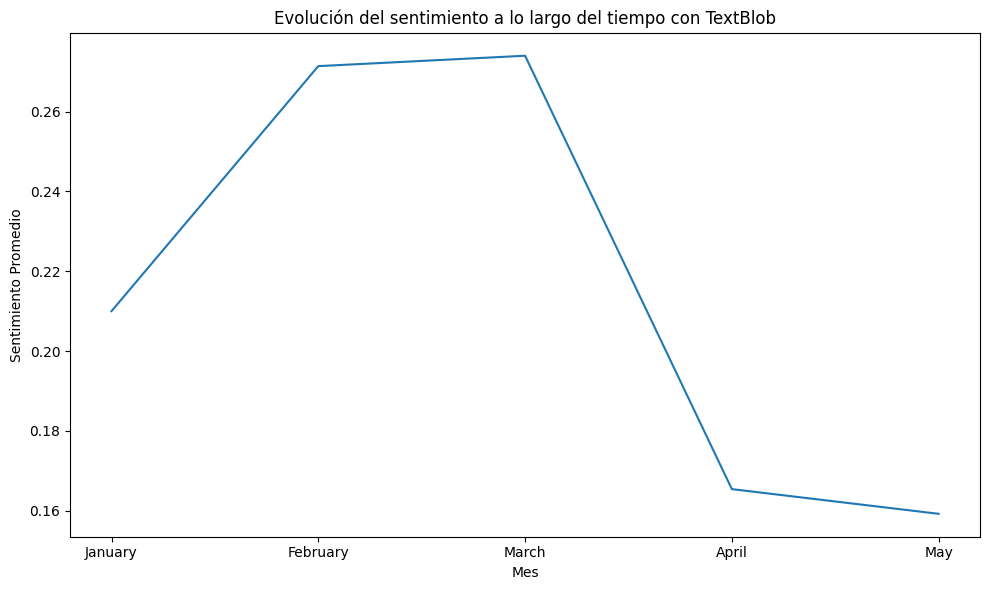

In [30]:
# Agrupa los comentarios por mes y calcula el promedio de sentimiento por TexBlob
dfve['Tiempo'] = pd.to_datetime(dfve['Tiempo'])
dfve['Mes'] = dfve['Tiempo'].dt.strftime('%B')  # Agrega una nueva columna 'Mes' con el nombre del mes
sentiment_by_month = dfve.groupby('Mes')['Polarity'].mean()

# Establecer el orden de los meses
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June']
sentiment_by_month = sentiment_by_month.reindex(ordered_months)

# Crea el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(sentiment_by_month.index, sentiment_by_month.values)
plt.xlabel('Mes')
plt.ylabel('Sentimiento Promedio')
plt.title('Evolución del sentimiento a lo largo del tiempo con TextBlob')
plt.tight_layout()
plt.show()

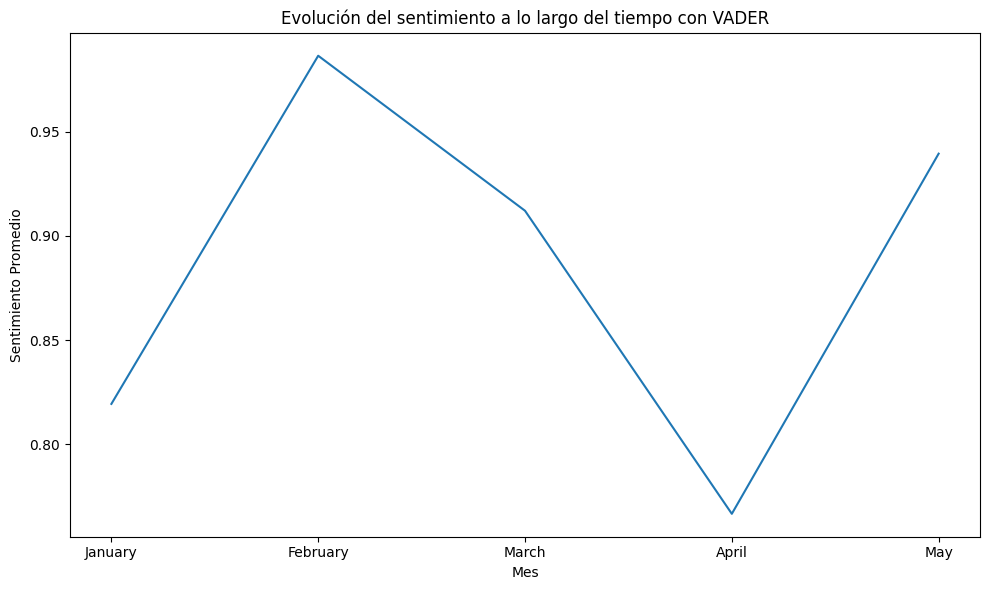

In [31]:
# Agrupa los comentarios por mes y calcula el promedio de sentimiento por VADER
dfve['Tiempo'] = pd.to_datetime(dfve['Tiempo'])
dfve['Mes'] = dfve['Tiempo'].dt.strftime('%B')  # Agrega una nueva columna 'Mes' con el nombre del mes
sentiment_by_month = dfve.groupby('Mes')['Vader Sentiment'].mean()

# Establecer el orden de los meses
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June']
sentiment_by_month = sentiment_by_month.reindex(ordered_months)

# Crea el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(sentiment_by_month.index, sentiment_by_month.values)
plt.xlabel('Mes')
plt.ylabel('Sentimiento Promedio')
plt.title('Evolución del sentimiento a lo largo del tiempo con VADER')
plt.tight_layout()
plt.show()

# The Night Agent



## Web Scraping

In [4]:
url = "https://www.imdb.com/title/tt13918776/reviews/?ref_=tt_ql_op_3"

In [5]:
response = requests.get(url)

# Crear el objeto BeautifulSoup
soup2 = BeautifulSoup(response.content, "html.parser")

In [29]:
response

<Response [200]>

In [6]:
# Listas para almacenar los datos
contents = []
dates = []

# Número máximo de páginas adicionales a obtener
max_pages = 10

# Iterar sobre las páginas de reseñas
for page in range(1, max_pages + 1):
    # URL de la página actual
    url = f"{url}?start={((page - 1) * 10)}"

    # Realizar la solicitud HTTP
    response = requests.get(url)

    # Crear el objeto BeautifulSoup
    soup2 = BeautifulSoup(response.content, "html.parser")

    # Encontrar todas las opiniones y reseñas
    reviews = soup2.find_all("div", class_="lister-item-content")

    # Iterar sobre las reseñas y extraer los detalles deseados
    for review in reviews:

        # Contenido de la reseña
        content = review.find("div", class_="text").text.strip()
        contents.append(content)

        # Fecha de la reseña
        date_element = review.find("span", class_="review-date")
        date_match = re.search(r'\d+\s\w+\s\d+', date_element.text.strip())
        date = date_match.group() if date_match else "N/A"
        dates.append(date)

# Crear el DataFrame
data = {
    "Reseña": contents,
    "Tiempo": dates
}

dfagent = pd.DataFrame(data)

dfagent.head()

,Reseña,Tiempo
0,I have to say that I came away impressed with ...,1 June 2023
1,I can't remember the last time a show surprise...,25 May 2023
2,This is a fast moving and fun action series th...,29 March 2023
3,I didn't even know of this show till being rec...,24 May 2023
4,If you like the first two episodes and see abs...,24 March 2023


In [31]:
dfagent.shape

(250, 2)

## Procesamiento de Texto

In [7]:
# Clean the text
def clean(text):
    # Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
dfagent['Reseña limpia'] = dfagent['Reseña'].apply(clean)
dfagent.head()

,Reseña,Tiempo,Reseña limpia
0,I have to say that I came away impressed with ...,1 June 2023,I have to say that I came away impressed with ...
1,I can't remember the last time a show surprise...,25 May 2023,I can t remember the last time a show surprise...
2,This is a fast moving and fun action series th...,29 March 2023,This is a fast moving and fun action series th...
3,I didn't even know of this show till being rec...,24 May 2023,I didn t even know of this show till being rec...
4,If you like the first two episodes and see abs...,24 March 2023,If you like the first two episodes and see abs...


### Tokenizacion

In [8]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
import nltk
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

dfagent['POS tagged'] = dfagent['Reseña limpia'].apply(token_stop_pos)
dfagent.head()
# mydata['POS tagged'][0]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,Reseña,Tiempo,Reseña limpia,POS tagged
0,I have to say that I came away impressed with ...,1 June 2023,I have to say that I came away impressed with ...,"[(say, v), (came, v), (away, r), (impressed, v..."
1,I can't remember the last time a show surprise...,25 May 2023,I can t remember the last time a show surprise...,"[(remember, v), (last, a), (time, n), (show, n..."
2,This is a fast moving and fun action series th...,29 March 2023,This is a fast moving and fun action series th...,"[(fast, a), (moving, n), (fun, a), (action, n)..."
3,I didn't even know of this show till being rec...,24 May 2023,I didn t even know of this show till being rec...,"[(even, r), (know, v), (show, n), (till, v), (..."
4,If you like the first two episodes and see abs...,24 March 2023,If you like the first two episodes and see abs...,"[(like, v), (first, a), (two, None), (episodes..."


### Lemmatizacion

In [9]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

dfagent['Lemma'] = dfagent['POS tagged'].apply(lemmatize)
dfagent.head()
# print(mydata['review'][239] + "\n" + mydata['Lemma'][239])

,Reseña,Tiempo,Reseña limpia,POS tagged,Lemma
0,I have to say that I came away impressed with ...,1 June 2023,I have to say that I came away impressed with ...,"[(say, v), (came, v), (away, r), (impressed, v...",say come away impress Night Agent actually l...
1,I can't remember the last time a show surprise...,25 May 2023,I can t remember the last time a show surprise...,"[(remember, v), (last, a), (time, n), (show, n...",remember last time show surprise much like l...
2,This is a fast moving and fun action series th...,29 March 2023,This is a fast moving and fun action series th...,"[(fast, a), (moving, n), (fun, a), (action, n)...",fast moving fun action series keep engage en...
3,I didn't even know of this show till being rec...,24 May 2023,I didn t even know of this show till being rec...,"[(even, r), (know, v), (show, n), (till, v), (...",even know show till recommend sister law din...
4,If you like the first two episodes and see abs...,24 March 2023,If you like the first two episodes and see abs...,"[(like, v), (first, a), (two, None), (episodes...",like first two episode see absolutely nothin...


## Análisis de Sentimiento

In [10]:
from textblob import TextBlob

# function to calculate subjectivity
def getSubjectivity2(review2):
    return TextBlob(review2).sentiment.subjectivity2

# function to calculate polarity
def getPolarity2(review2):
    return TextBlob(review2).sentiment.polarity2

# function to analyze the reviews
def analysis(score2):
    if score2 < 0:
        return 'Negative'
    elif score2 == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [32]:
dfa = pd.DataFrame(dfagent[['Tiempo', 'Reseña limpia', 'Lemma']])

In [33]:
dfa['Polarity'] = dfa['Lemma'].apply(getPolarity)
dfa['Analysis'] = dfa['Polarity'].apply(analysis)
dfa.head()

,Tiempo,Reseña limpia,Lemma,Polarity,Analysis
0,1 June 2023,I have to say that I came away impressed with ...,say come away impress Night Agent actually l...,0.050000,Positive
1,25 May 2023,I can t remember the last time a show surprise...,remember last time show surprise much like l...,0.231439,Positive
2,29 March 2023,This is a fast moving and fun action series th...,fast moving fun action series keep engage en...,0.195000,Positive
3,24 May 2023,I didn t even know of this show till being rec...,even know show till recommend sister law din...,0.145686,Positive
4,24 March 2023,If you like the first two episodes and see abs...,like first two episode see absolutely nothin...,0.048529,Positive


In [34]:
tb_counts = dfa.Analysis.value_counts()
tb_counts

Positive    190
Negative     60
Name: Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x7f95b1c2de40>,
 [Text(-0.8018654676031945, 0.7530018405458982, 'Positive'),
  Text(0.874762289839236, -0.8214565942733776, 'Negative')],
 [Text(-0.43738116414719697, 0.41072827666139905, '76.0%'),
  Text(0.5102780024062209, -0.4791830133261369, '24.0%')])

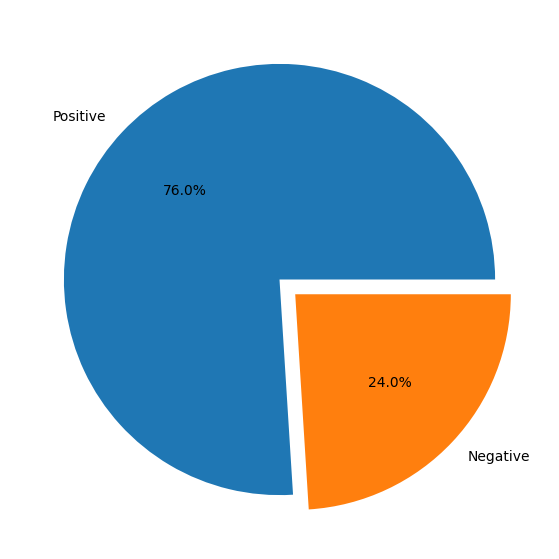

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

tb_count= dfa.Analysis.value_counts()
plt.figure(figsize=(10, 7))
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0.1), autopct='%1.1f%%', shadow=False)
# plt.legend()

Analisis con VADER

In [36]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

dfa['Vader Sentiment'] = dfa['Lemma'].apply(vadersentimentanalysis)

In [37]:
# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'

dfa['Vader Analysis'] = dfa['Vader Sentiment'].apply(vader_analysis)
dfa.head()

,Tiempo,Reseña limpia,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis
0,1 June 2023,I have to say that I came away impressed with ...,say come away impress Night Agent actually l...,0.050000,Positive,0.3182,Neutral
1,25 May 2023,I can t remember the last time a show surprise...,remember last time show surprise much like l...,0.231439,Positive,0.9750,Positive
2,29 March 2023,This is a fast moving and fun action series th...,fast moving fun action series keep engage en...,0.195000,Positive,0.5423,Positive
3,24 May 2023,I didn t even know of this show till being rec...,even know show till recommend sister law din...,0.145686,Positive,0.9387,Positive
4,24 March 2023,If you like the first two episodes and see abs...,like first two episode see absolutely nothin...,0.048529,Positive,0.6967,Positive


In [38]:
vader_counts = dfa['Vader Analysis'].value_counts()
vader_counts

Positive    170
Negative     50
Neutral      30
Name: Vader Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x7f95b1b5c9a0>,
 [Text(-0.6429921767416813, 1.013193496154113, 'Positive'),
  Text(0.20611950472011625, -1.0805159646085447, 'Negative'),
  Text(1.0227541568457088, -0.40493695145642544, 'Neutral')],
 [Text(-0.37507876976598076, 0.5910295394232326, '68.0%'),
  Text(0.11242882075642703, -0.5893723443319334, '20.0%'),
  Text(0.5578659037340229, -0.22087470079441385, '12.0%')])

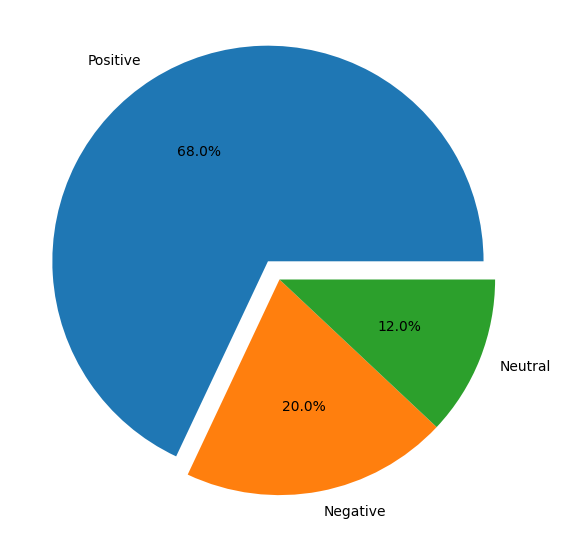

In [39]:
vader_counts= dfa['Vader Analysis'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)
# plt.legend()

## Visualización de Datos

In [40]:
dfa

,Tiempo,Reseña limpia,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis
0,1 June 2023,I have to say that I came away impressed with ...,say come away impress Night Agent actually l...,0.050000,Positive,0.3182,Neutral
1,25 May 2023,I can t remember the last time a show surprise...,remember last time show surprise much like l...,0.231439,Positive,0.9750,Positive
2,29 March 2023,This is a fast moving and fun action series th...,fast moving fun action series keep engage en...,0.195000,Positive,0.5423,Positive
3,24 May 2023,I didn t even know of this show till being rec...,even know show till recommend sister law din...,0.145686,Positive,0.9387,Positive
4,24 March 2023,If you like the first two episodes and see abs...,like first two episode see absolutely nothin...,0.048529,Positive,0.6967,Positive
...,...,...,...,...,...,...,...
245,20 April 2023,The show is simply not believable It started o...,show simply believable start great premise m...,-0.166040,Negative,-0.9670,Negative
246,12 May 2023,From the first episode I was hooked and couldn...,first episode hook stop watch Binged whole s...,0.103810,Positive,0.9070,Positive
247,1 April 2023,Don t understand the great reviews this was te...,understand great review terribly bad manage ...,-0.026905,Negative,-0.8723,Negative
248,14 April 2023,Nowadays it s so usual to watch the first epis...,Nowadays usual watch first episode new serie...,-0.040215,Negative,-0.9152,Negative


In [46]:
dfa.shape

(250, 7)

([<matplotlib.patches.Wedge at 0x7f95b5a4b310>,
 [Text(-0.5894094953465412, 0.9287607048079368, 'Positive'),
  Text(0.20611950472011625, -1.0805159646085447, 'Negative'),
  Text(1.115731807468046, -0.44174940158882775, 'Neutral')],
 [Text(-0.32149608837084065, 0.5065967480770565, '68.0%'),
  Text(0.11242882075642703, -0.5893723443319334, '20.0%'),
  Text(0.6508435543563601, -0.25768715092681616, '12.0%')])

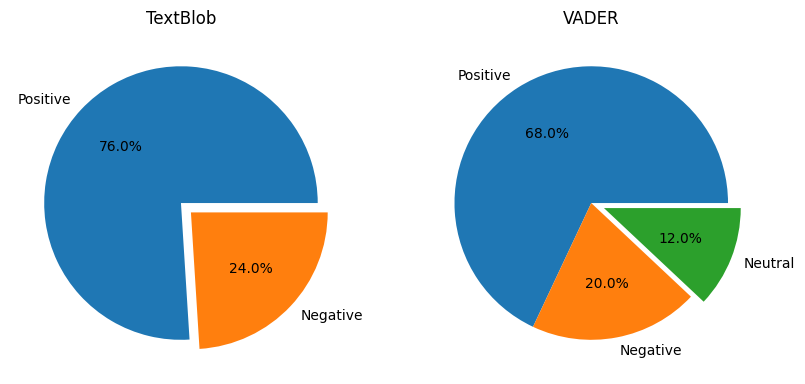

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title("TextBlob")
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0.1), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,2)
plt.title("VADER")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.1), autopct='%1.1f%%', shadow=False)

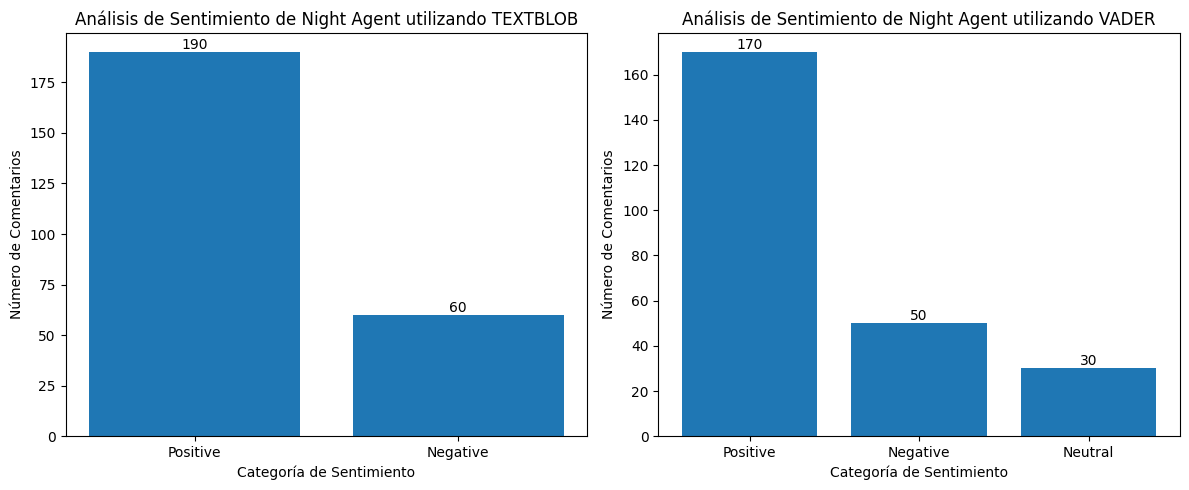

In [42]:
# Obtener el conteo de las categorías de sentimiento de dfa utilizando TEXTBLOB
sentimiento_counts_textblob_dfa = dfa['Analysis'].value_counts()

# Obtener el conteo de las categorías de sentimiento de dfa utilizando VADER
sentimiento_counts_vader_dfa = dfa['Vader Analysis'].value_counts()

# Crear una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 3: Análisis de sentimiento de dfa utilizando TEXTBLOB
axes[0].bar(sentimiento_counts_textblob_dfa.index, sentimiento_counts_textblob_dfa.values)
for i, count in enumerate(sentimiento_counts_textblob_dfa.values):
    axes[0].text(i, count, str(count), ha='center', va='bottom')
axes[0].set_title('Análisis de Sentimiento de Night Agent utilizando TEXTBLOB')
axes[0].set_xlabel('Categoría de Sentimiento')
axes[0].set_ylabel('Número de Comentarios')

# Gráfico 4: Análisis de sentimiento de dfa utilizando VADER
axes[1].bar(sentimiento_counts_vader_dfa.index, sentimiento_counts_vader_dfa.values)
for i, count in enumerate(sentimiento_counts_vader_dfa.values):
    axes[1].text(i, count, str(count), ha='center', va='bottom')
axes[1].set_title('Análisis de Sentimiento de Night Agent utilizando VADER')
axes[1].set_xlabel('Categoría de Sentimiento')
axes[1].set_ylabel('Número de Comentarios')

plt.tight_layout()
plt.show()


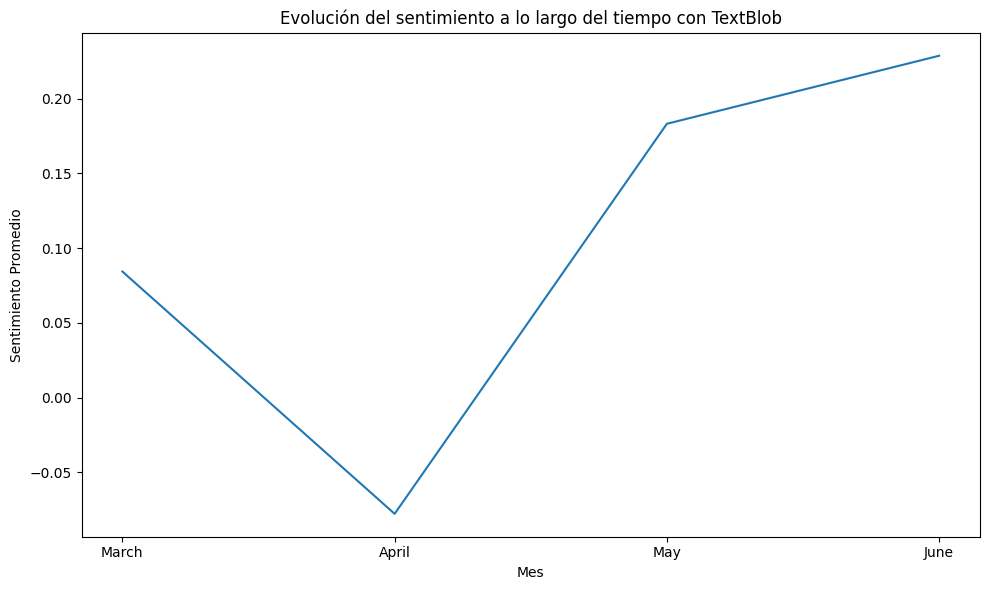

In [44]:
# Agrupa los comentarios por mes y calcula el promedio de sentimiento por TextBlob
dfa['Tiempo'] = pd.to_datetime(dfa['Tiempo'])
dfa['Mes'] = dfa['Tiempo'].dt.strftime('%B')  # Agrega una nueva columna 'Mes' con el nombre del mes
sentiment_by_month = dfa.groupby('Mes')['Polarity'].mean()

# Establecer el orden de los meses
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sentiment_by_month = sentiment_by_month.reindex(ordered_months)

# Crea el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(sentiment_by_month.index, sentiment_by_month.values)
plt.xlabel('Mes')
plt.ylabel('Sentimiento Promedio')
plt.title('Evolución del sentimiento a lo largo del tiempo con TextBlob')
plt.tight_layout()
plt.show()

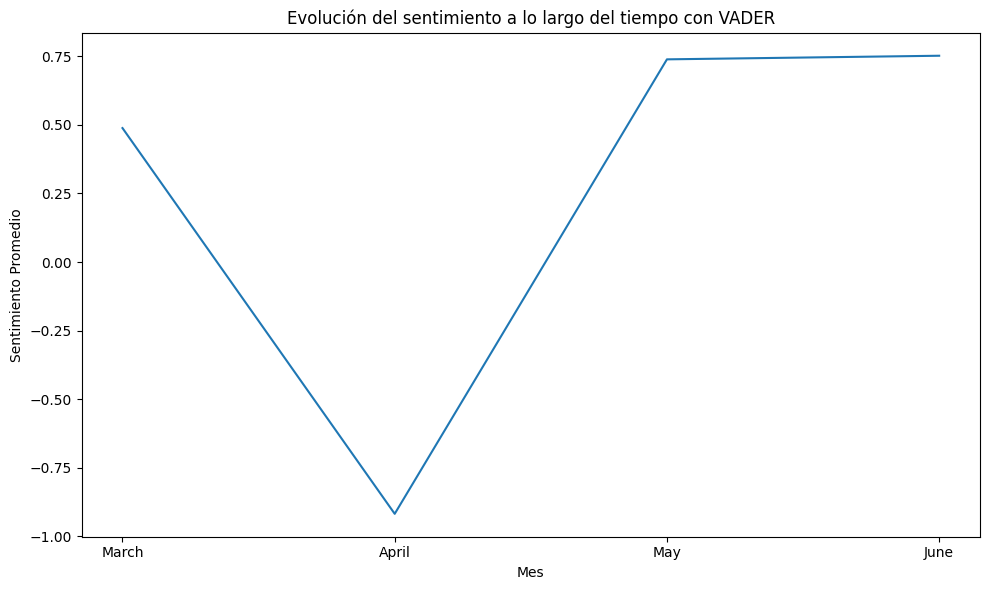

In [45]:
# Agrupa los comentarios por mes y calcula el promedio de sentimiento por VADER
dfa['Tiempo'] = pd.to_datetime(dfa['Tiempo'])
dfa['Mes'] = dfa['Tiempo'].dt.strftime('%B')  # Agrega una nueva columna 'Mes' con el nombre del mes
sentiment_by_month = dfa.groupby('Mes')['Vader Sentiment'].mean()

# Establecer el orden de los meses
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sentiment_by_month = sentiment_by_month.reindex(ordered_months)

# Crea el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(sentiment_by_month.index, sentiment_by_month.values)
plt.xlabel('Mes')
plt.ylabel('Sentimiento Promedio')
plt.title('Evolución del sentimiento a lo largo del tiempo con VADER')
plt.tight_layout()
plt.show()

## Conclusiones

Luego de haber analizado y visualizado todos los resultados de los comentarios que obtuvieron la película y la serie ante los reviews de los usuarios podemos observar que la mayoría de los comentarios tanto para el peor vecino del mundo y The Night Agent son positivos, tanto en el análisis de TexBlob como con VADER se ha llegado a la misma conclusión, esto demuestra la experiencia generalmente positiva que tiene la gente al observar la serie y/o la película. Yendo a los números podemos ver que Night Agent tiene 76% de comentarios positivos con TextBlob y 68% con VADER. El peor vecino del mundo tiene 92% de comentarios positivos, tanto con TextBlob como con VADER. Analizando la evaluación de sentimiento a través del tiempo es posible analizar que tanto la serie como la película tuvieron una caída en el mes de abril. En cuanto a las diferencias de sentimiento entre los géneros de las películas o directores específicos, se debería hacer un análisis más detallado agrupando más películas o películas por director y así obtener un mejor resultado. En nuestro análisis vemos que la serie de acción, drama y suspenso le fue bastante bien con el publico aunque un poco menor que a la película de comedia y drama, no quiere decir que siempre sea así pero podría ser una pequeña muestra. Cabe resaltar que El Peor Vecino del Mundo tiene de actor principal al reconocido Tom Hanks.
